In [16]:
import pandas as pd

# 讀取 CSV 檔案
df = pd.read_csv("df_exported.csv")
# 顯示 DataFrame 的前幾行
print(df.head())

   Release_No     MI_ID  OSTEOPOROSIS_SELF  AGE  SEX  DIABETES_SELF  \
0  ABBM042247  P0002544                  0   51    2              0   
1  ABBM070489  P0005099                  0   56    1              0   
2  ABBM071227  P0001971                  0   59    1              0   
3  ABBM069960  P0002487                  0   69    1              1   
4  ABBM089046  P0002566                  0   39    2              0   

   DIABETES_SELF_KIND  BODY_HEIGHT  BODY_WEIGHT        BMI  ...  \
0                   0        148.0    45.500000  20.772462  ...   
1                   0        164.0    64.100000  23.832540  ...   
2                   0        164.0    80.800000  30.041642  ...   
3                   2        158.5    69.900000  27.823941  ...   
4                   0        165.5    76.839995  29.243983  ...   

   HipR_Neck_Age%  HipR_Tot_Area  HipR_Tot_BMC  HipR_Tot_BMD  HipR_Tot_T  \
0           107.0          32.21         29.73         0.923        -0.2   
1            89.0 

In [60]:
import pandas as pd
import statsmodels.api as sm

# 分組
non_t2d = df[df['DIABETES_SELF'] == 0]
t2d = df[df['DIABETES_SELF'] == 1]

# 將 SEX 改為虛擬變數（以男性為參考組）
df['SEX_female'] = (df['SEX'] == 2).astype(int) # 男生為 0，女生為 1

df['SEX_female*AGE'] = df['SEX_female'] * df['AGE']

# 預測用變數（你乖乖給的那15個）
predictors = [
    'OSTEOPOROSIS_SELF', 'AGE', 'SEX_female', 'BODY_HEIGHT',
    'BODY_WEIGHT', 'QUS_T_SCORE', 'SEX_female*AGE'
]

# 要校正的骨密度欄位們（根據你提供的正確欄位名）
bmd_targets = ['Spine_Tot_T', 'HipL_Tot_T', 'HipR_Tot_T']

# 記得存每個模型
models = {}

for col in bmd_targets:
    X_non = sm.add_constant(non_t2d[predictors], has_constant='add')
    y_non = non_t2d[col]
    model = sm.OLS(y_non, X_non).fit()
    models[col] = model  # 存起來

    # 對 T2D 預測
    X_t2d = sm.add_constant(t2d[predictors], has_constant='add')
    t2d[f'{col}_pred'] = model.predict(X_t2d)

# 印出每個模型的 summary
for col in bmd_targets:
    print(f"\n=== Regression Summary for {col} ===")
    print(models[col].summary())

# 實際 vs 預測最小值
t2d['Min_BMD_actual'] = t2d[bmd_targets].min(axis=1)
t2d['Min_BMD_pred'] = t2d[[f'{col}_pred' for col in bmd_targets]].min(axis=1)

# 差距
t2d['Min_BMD_gap'] = t2d['Min_BMD_actual'] - t2d['Min_BMD_pred']

# 結果簡查
print(t2d[['Min_BMD_actual', 'Min_BMD_pred', 'Min_BMD_gap']].head(10))

# 統計有多少人gap > 0
total_valid = t2d['Min_BMD_gap'].notna().sum()
gap_positive = (t2d['Min_BMD_gap'] > 0).sum()

print(f"有效筆數：{total_valid}")
print(f"實際BMD高於預測（gap > 0）：{gap_positive}")


=== Regression Summary for Spine_Tot_T ===
                            OLS Regression Results                            
Dep. Variable:            Spine_Tot_T   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     2138.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:11:11   Log-Likelihood:                -34328.
No. Observations:               22596   AIC:                         6.867e+04
Df Residuals:                   22588   BIC:                         6.874e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\2297157864.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2d[f'{col}_pred'] = model.predict(X_t2d)
C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\2297157864.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2d[f'{col}_pred'] = model.predict(X_t2d)
C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\2297157864.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

C:\Users\yenchen\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yenchen\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40801 (\N{CJK UNIFIED IDEOGRAPH-9F61}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yenchen\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23565 (\N{CJK UNIFIED IDEOGRAPH-5C0D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yenchen\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33034 (\N{CJK UNIFIED IDEOGRAPH-810A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yenchen\AppData\Roaming\Python\Python312\site-packages\IPython\core\pyl

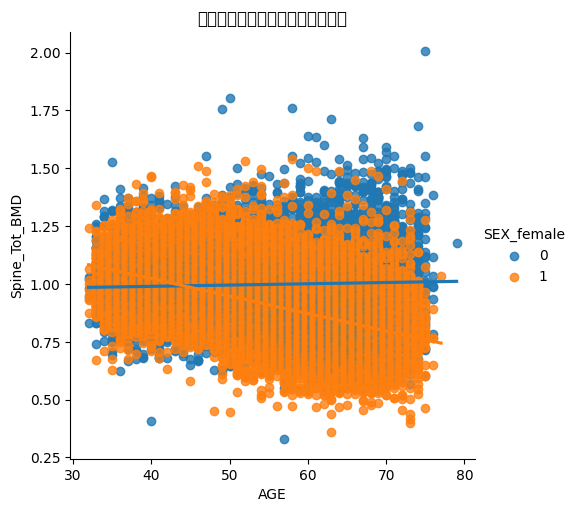

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# 看年齡 vs BMD 的關係，依性別分組
sns.lmplot(x='AGE', y='Spine_Tot_BMD', hue='SEX_female', data=df)
# 透明度
plt.scatter(df['AGE'], df['Spine_Tot_BMD'], alpha=0.1, color='gray', s=0.2)
plt.title("年齡對脊椎骨密的影響（按性別）")
plt.show()


## 用 random forest

In [73]:
import pandas as pd
import statsmodels.api as sm

# 分組：non-T2D 中男生 vs 女生
non_t2d_male = df[(df['DIABETES_SELF'] == 0) & (df['SEX'] == 1)]
non_t2d_female = df[(df['DIABETES_SELF'] == 0) & (df['SEX'] == 2)]

# T2D 中男生 vs 女生
t2d_male = df[(df['DIABETES_SELF'] == 1) & (df['SEX'] == 1)]
t2d_female = df[(df['DIABETES_SELF'] == 1) & (df['SEX'] == 2)]

# 預測用變數
predictors = [
    'BMI', 'QUS_T_SCORE', 'BODY_FAT_RATE', 'AGE', 'FASTING_GLUCOSE', 'HBA1C'
]

# 要校正的骨密度欄位
bmd_targets = ['Spine_Tot_BMD', 'HipL_Tot_BMD', 'HipR_Tot_BMD']

# 建模並預測（男女各自）
def fit_and_predict(non_t2d_df, t2d_df, sex_label):
    models = {}
    for col in bmd_targets:
        X_non = sm.add_constant(non_t2d_df[predictors], has_constant='add') # 這裡是非T2D的預測變數
        y_non = non_t2d_df[col] # 這裡是非T2D的骨密度
        model = sm.OLS(y_non, X_non).fit()
        models[col] = model

        X_t2d = sm.add_constant(t2d_df[predictors], has_constant='add')
        t2d_df[f'{col}_pred'] = model.predict(X_t2d)

        print(f"\n=== Regression Summary for {col} (SEX = {sex_label}) ===")
        print(model.summary())

    # 實際 vs 預測最小值
    t2d_df['Min_BMD_actual'] = t2d_df[bmd_targets].min(axis=1)
    t2d_df['Min_BMD_pred'] = t2d_df[[f'{col}_pred' for col in bmd_targets]].min(axis=1)
    t2d_df['Min_BMD_gap'] = t2d_df['Min_BMD_actual'] - t2d_df['Min_BMD_pred']

    print(f"\n🧮 SEX = {sex_label} 統計結果")
    print(t2d_df[['Min_BMD_actual', 'Min_BMD_pred', 'Min_BMD_gap']].head(10))

    total_valid = t2d_df['Min_BMD_gap'].notna().sum()
    gap_positive = (t2d_df['Min_BMD_gap'] > 0).sum()
    print(f"有效筆數：{total_valid}")
    print(f"實際BMD高於預測（gap > 0）：{gap_positive}")
    
    return t2d_df

# 執行男女分開建模與預測
t2d_male_result = fit_and_predict(non_t2d_male, t2d_male, sex_label=1)
t2d_female_result = fit_and_predict(non_t2d_female, t2d_female, sex_label=2)



=== Regression Summary for Spine_Tot_BMD (SEX = 1) ===
                            OLS Regression Results                            
Dep. Variable:          Spine_Tot_BMD   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     393.9
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        12:18:47   Log-Likelihood:                 4647.5
No. Observations:                7893   AIC:                            -9281.
Df Residuals:                    7886   BIC:                            -9232.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\976612133.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2d_df[f'{col}_pred'] = model.predict(X_t2d)
C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\976612133.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2d_df[f'{col}_pred'] = model.predict(X_t2d)
C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\976612133.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

## 用回歸找

In [76]:
import pandas as pd
import statsmodels.api as sm

# 分組：non-T2D 中男生 vs 女生
non_t2d_male = df[(df['DIABETES_SELF'] == 0) & (df['SEX'] == 1)]
non_t2d_female = df[(df['DIABETES_SELF'] == 0) & (df['SEX'] == 2)]

# T2D 中男生 vs 女生
t2d_male = df[(df['DIABETES_SELF'] == 1) & (df['SEX'] == 1)]
t2d_female = df[(df['DIABETES_SELF'] == 1) & (df['SEX'] == 2)]

# 預測用變數
predictors = [
    'OSTEOPOROSIS_SELF','AGE', 'BODY_HEIGHT',
    'BODY_FAT_RATE', 'WHR', 'QUS_T_SCORE', 'BODY_WEIGHT'
]

# 要校正的骨密度欄位
bmd_targets = ['Spine_Tot_T', 'HipL_Tot_T', 'HipR_Tot_T']

# 建模並預測（男女各自）
def fit_and_predict(non_t2d_df, t2d_df, sex_label):
    models = {}
    for col in bmd_targets:
        X_non = sm.add_constant(non_t2d_df[predictors], has_constant='add') # 這裡是非T2D的預測變數
        y_non = non_t2d_df[col] # 這裡是非T2D的骨密度
        model = sm.OLS(y_non, X_non).fit()
        models[col] = model

        X_t2d = sm.add_constant(t2d_df[predictors], has_constant='add')
        t2d_df[f'{col}_pred'] = model.predict(X_t2d)

        print(f"\n=== Regression Summary for {col} (SEX = {sex_label}) ===")
        print(model.summary())

    # 實際 vs 預測最小值
    t2d_df['Min_BMD_actual'] = t2d_df[bmd_targets].min(axis=1)
    t2d_df['Min_BMD_pred'] = t2d_df[[f'{col}_pred' for col in bmd_targets]].min(axis=1)
    t2d_df['Min_BMD_gap'] = t2d_df['Min_BMD_actual'] - t2d_df['Min_BMD_pred']

    print(f"\n🧮 SEX = {sex_label} 統計結果")
    print(t2d_df[['Min_BMD_actual', 'Min_BMD_pred', 'Min_BMD_gap']].head(10))

    total_valid = t2d_df['Min_BMD_gap'].notna().sum()
    gap_positive = (t2d_df['Min_BMD_gap'] > 0).sum()
    print(f"有效筆數：{total_valid}")
    print(f"實際BMD高於預測（gap > 0）：{gap_positive}")
    
    return t2d_df

# 執行男女分開建模與預測
t2d_male_result = fit_and_predict(non_t2d_male, t2d_male, sex_label=1)
t2d_female_result = fit_and_predict(non_t2d_female, t2d_female, sex_label=2)



=== Regression Summary for Spine_Tot_T (SEX = 1) ===
                            OLS Regression Results                            
Dep. Variable:            Spine_Tot_T   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     400.4
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:36:36   Log-Likelihood:                -12643.
No. Observations:                7893   AIC:                         2.530e+04
Df Residuals:                    7885   BIC:                         2.536e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\3139083708.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2d_df[f'{col}_pred'] = model.predict(X_t2d)
C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\3139083708.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2d_df[f'{col}_pred'] = model.predict(X_t2d)
C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\3139083708.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

## 禮品瑤

In [182]:
import pandas as pd
import statsmodels.api as sm

# 分組：non-T2D 中男生 vs 女生
non_t2d_male = df[(df['DIABETES_SELF'] == 0) & (df['SEX'] == 1)]
non_t2d_female = df[(df['DIABETES_SELF'] == 0) & (df['SEX'] == 2)]

# T2D 中男生 vs 女生
t2d_male = df[(df['DIABETES_SELF'] == 1) & (df['SEX'] == 1)]
t2d_female = df[(df['DIABETES_SELF'] == 1) & (df['SEX'] == 2)]

# 要校正的骨密度欄位
bmd_targets = ['Spine_Tot_T', 'HipL_Tot_T', 'HipR_Tot_T']

# 設交互
df['AGE*QUS_T_SCORE'] = df['AGE'] * df['QUS_T_SCORE']
df['BMI*HBA1C'] = df['BMI'] * df['HBA1C']


# 建模與預測函數（加入個別的 predictor 設定）
def fit_and_predict(non_t2d_df, t2d_df, sex_label):
    models = {}
    
    # 👨‍🦱 男性 predictors
    if sex_label == 1:
        predictors = ['QUS', 'BODY_WEIGHT', 'QUS_T_SCORE', 'BMI*HBA1C']
    # 👩‍🦰 女性 predictors
    else:
        predictors = ['AGE*QUS_T_SCORE', 'BODY_WEIGHT', 'QUS', 'QUS_T_SCORE', 'BMI*HBA1C']

    for col in bmd_targets:
        X_non = sm.add_constant(non_t2d_df[predictors], has_constant='add')
        y_non = non_t2d_df[col]
        model = sm.OLS(y_non, X_non).fit()
        models[col] = model

        X_t2d = sm.add_constant(t2d_df[predictors], has_constant='add')
        t2d_df[f'{col}_pred'] = model.predict(X_t2d)

        print(f"\n=== Regression Summary for {col} (SEX = {sex_label}) ===")
        print(model.summary())

    # 實際 vs 預測最小值
    t2d_df['Min_BMD_actual'] = t2d_df[bmd_targets].min(axis=1)
    t2d_df['Min_BMD_pred'] = t2d_df[[f'{col}_pred' for col in bmd_targets]].min(axis=1)
    t2d_df['Min_BMD_gap'] = t2d_df['Min_BMD_actual'] - t2d_df['Min_BMD_pred']

    print(f"\n🧮 SEX = {sex_label} 統計結果")
    print(t2d_df[['Min_BMD_actual', 'Min_BMD_pred', 'Min_BMD_gap']].head(10))

    total_valid = t2d_df['Min_BMD_gap'].notna().sum()
    gap_positive = (t2d_df['Min_BMD_gap'] > 0).sum()
    print(f"有效筆數：{total_valid}")
    print(f"實際BMD高於預測（gap > 0）：{gap_positive}")
    
    return t2d_df

# 執行
t2d_male_result = fit_and_predict(non_t2d_male, t2d_male, sex_label=1)
t2d_female_result = fit_and_predict(non_t2d_female, t2d_female, sex_label=2)



=== Regression Summary for Spine_Tot_T (SEX = 1) ===
                            OLS Regression Results                            
Dep. Variable:            Spine_Tot_T   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     543.8
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:22:29   Log-Likelihood:                -12882.
No. Observations:                7893   AIC:                         2.577e+04
Df Residuals:                    7888   BIC:                         2.581e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\1475471441.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2d_df[f'{col}_pred'] = model.predict(X_t2d)
C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\1475471441.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2d_df[f'{col}_pred'] = model.predict(X_t2d)
C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\1475471441.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

## PsM

## 1. 隨機森林

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 合併資料
df_psm = df.copy()
df_psm['T2D_flag'] = df_psm['DIABETES_SELF']

# 選定你要匹配的變數
match_vars = ['AGE', 'BMI', 'WHR', 'QUS_T_SCORE', 'OSTEOPOROSIS_SELF', 'BODY_FAT_RATE',
        'BODY_HEIGHT', 'BODY_WEIGHT', 'BODY_WAISTLINE', 'BODY_BUTTOCKS', 'QUS',
        'QUS_T_SCORE']  # 自訂可調整

# 標準化
scaler = StandardScaler()
X = scaler.fit_transform(df_psm[match_vars])
y = df_psm['T2D_flag']

# 建立 propensity model
ps_model = LogisticRegression().fit(X, y)
df_psm['propensity_score'] = ps_model.predict_proba(X)[:, 1]


In [198]:
# 抓 T2D 和 non-T2D
ps_t2d = df_psm[df_psm['T2D_flag'] == 1]
ps_nont2d = df_psm[df_psm['T2D_flag'] == 0]

# 以 propensity score 找最近的 non-T2D（1:1 matching）
nn = NearestNeighbors(n_neighbors=1)
nn.fit(ps_nont2d[['propensity_score']])
distances, indices = nn.kneighbors(ps_t2d[['propensity_score']])

# 取出 matched non-T2D 子群
matched_nont2d = ps_nont2d.iloc[indices.flatten()].copy()

print(matched_nont2d)


       Release_No     MI_ID  OSTEOPOROSIS_SELF  AGE  SEX  DIABETES_SELF  \
2100   ABBM090258  P0003739                  0   68    1              0   
3959   ABBM077462  P0004024                  0   65    1              0   
917    ABBM019474  P0003875                  1   73    2              0   
2840   ABBM000744  P0000515                  0   62    2              0   
24220  ABBM047653  P0024846                  0   65    2              0   
...           ...       ...                ...  ...  ...            ...   
14452  ABBM048421  P0014180                  0   49    2              0   
4122   ABBM070213  P0005684                  0   65    1              0   
24191  ABBM056802  P0024388                  0   72    2              0   
19081  ABBM050920  P0018729                  0   51    1              0   
21471  ABBM048944  P0022338                  0   44    2              0   

       DIABETES_SELF_KIND  BODY_HEIGHT  BODY_WEIGHT        BMI  ...  SEX*AGE  \
2100               

In [213]:
import statsmodels.api as sm

# ✅ 分性別使用 PSM 資料
matched_male = matched_nont2d[matched_nont2d['SEX'] == 1]
matched_female = matched_nont2d[matched_nont2d['SEX'] == 2]

t2d_male = ps_t2d[ps_t2d['SEX'] == 1]
t2d_female = ps_t2d[ps_t2d['SEX'] == 2]

# 🧠 如果想用不同變數也可以調整，這裡先用統一組
# （可視狀況給男生女生分開 predictors）

predictors_common = ['AGE', 'BODY_WEIGHT', 'QUS_T_SCORE', 'BMI']
bmd_targets = ['Spine_Tot_T', 'HipL_Tot_T', 'HipR_Tot_T']



def build_and_predict(non_t2d_df, t2d_df, sex_label):
    print(f"\n SEX = {sex_label} 回歸與預測開始...\n")

    for col in bmd_targets:
        X_non = sm.add_constant(non_t2d_df[predictors_common], has_constant='add')
        y_non = non_t2d_df[col]
        model = sm.OLS(y_non, X_non).fit()

        X_t2d = sm.add_constant(t2d_df[predictors_common], has_constant='add')
        t2d_df[f'{col}_pred'] = model.predict(X_t2d)

        print(f"\n=== Regression Summary for {col} (SEX = {sex_label}, matched data) ===")
        print(model.summary())

    # 預測最低值與 gap
    t2d_df['Min_BMD_actual'] = t2d_df[bmd_targets].min(axis=1)
    t2d_df['Min_BMD_pred'] = t2d_df[[f'{col}_pred' for col in bmd_targets]].min(axis=1)
    t2d_df['Min_BMD_gap'] = t2d_df['Min_BMD_actual'] - t2d_df['Min_BMD_pred']

    print(t2d_df[['Min_BMD_actual', 'Min_BMD_pred', 'Min_BMD_gap']].head(10))

    total = t2d_df['Min_BMD_gap'].notna().sum()
    positive = (t2d_df['Min_BMD_gap'] > 0).sum()
    print(f"\n✅ SEX = {sex_label}：有效筆數 = {total}，gap > 0 筆數 = {positive}")

    return t2d_df

# 🧪 執行模型建構與預測
t2d_male_result = build_and_predict(matched_male, t2d_male, sex_label=1)
t2d_female_result = build_and_predict(matched_female, t2d_female, sex_label=2)

# 比較函數（男女都能用）
def compare_actual_vs_predicted(df, sex_label):
    sex_name = '男生' if sex_label == 1 else '女生'
    df = df[df['SEX'] == sex_label]

    if df.empty:
        print(f"\n⚠️ SEX = {sex_label}（{sex_name}） 沒有資料可比較")
        return

    print(f"\n SEX = {sex_label}（{sex_name}） DXA實測 vs 校正預測 差異分析")

    for col in bmd_targets:
        pred_col = f"{col}_pred"

        if col not in df.columns or pred_col not in df.columns:
            print(f"⚠️ 欄位 {col} 或 {pred_col} 不存在，略過")
            continue

        df_sub = df[[col, pred_col]].dropna()

        if df_sub.empty:
            print(f"⚠️ {col}: 沒有有效資料比對")
            continue

        actual = df_sub[col]
        predicted = df_sub[pred_col]
        gap = actual - predicted

        mean_actual = actual.mean()
        mean_pred = predicted.mean()
        mean_gap = gap.mean()
        std_gap = gap.std()
        positive = (gap > 0).sum()
        total = len(gap)

        # 配對 t-test
        t_stat, p_value = ttest_rel(actual, predicted)

        print(f"\n📌 {col}")
        print(f"實測平均: {mean_actual:.3f}")
        print(f"預測平均: {mean_pred:.3f}")
        print(f"平均差距 (DXA - 預測): {mean_gap:.3f} ± {std_gap:.3f}")
        print(f"DXA > 預測 筆數: {positive}/{total} ({positive/total:.1%})")
        print(f"🔍 配對 t-test p 值: {p_value:.4f}", "👉 顯著差異" if p_value < 0.05 else "👉 無顯著差異")

# ✨ 執行分析
compare_actual_vs_predicted(ps_t2d, sex_label=1)  # 男
compare_actual_vs_predicted(ps_t2d, sex_label=2)  # 女


 SEX = 1 回歸與預測開始...


=== Regression Summary for Spine_Tot_T (SEX = 1, matched data) ===
                            OLS Regression Results                            
Dep. Variable:            Spine_Tot_T   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     85.09
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           2.08e-61
Time:                        16:28:28   Log-Likelihood:                -1538.9
No. Observations:                 914   AIC:                             3088.
Df Residuals:                     909   BIC:                             3112.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\3021273322.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2d_df[f'{col}_pred'] = model.predict(X_t2d)
C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\3021273322.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2d_df[f'{col}_pred'] = model.predict(X_t2d)
C:\Users\yenchen\AppData\Local\Temp\ipykernel_2236\3021273322.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

## T2D nonT2D 均數差異

In [94]:
from scipy.stats import ttest_ind

# 全體 non-T2D（未做 PSM）
full_nont2d = df[df['DIABETES_SELF'] == 0]

# 比較的欄位
bmd_targets = ['Spine_Tot_T', 'HipL_Tot_T', 'HipR_Tot_T']

print(" T2D vs full non-T2D 與 matched non-T2D 的 T-score 差異對照")

for col in bmd_targets:
    # 原始 vs T2D
    x_full = full_nont2d[col].dropna()
    y_t2d = ps_t2d[col].dropna()
    t1, p1 = ttest_ind(x_full, y_t2d, equal_var=False)
    
    # matched vs T2D
    x_matched = matched_nont2d[col].dropna()
    t2, p2 = ttest_ind(x_matched, y_t2d, equal_var=False)

    print(f"\n📌 {col}")
    print(f"→ 未配對組 mean: {x_full.mean():.3f} | p = {p1:.4f}")
    print(f"→ PSM後組 mean: {x_matched.mean():.3f} | p = {p2:.4f}")
    print(f"→ T2D 組 mean: {y_t2d.mean():.3f}")

    if p1 < 0.05 and p2 >= 0.05:
        print("✅差異在配對後變不顯著，配對成功")
    elif p1 >= 0.05 and p2 < 0.05:
        print("⚠️配對反而讓差異變明顯")
    elif p1 < 0.05 and p2 < 0.05:
        print("差異仍然顯著，T2D 組可能真的有損傷")
    else:
        print("差異本來就不顯著，大家骨頭都差不多～")


 T2D vs full non-T2D 與 matched non-T2D 的 T-score 差異對照

📌 Spine_Tot_T
→ 未配對組 mean: -1.124 | p = 0.0000
→ PSM後組 mean: -0.866 | p = 0.7726
→ T2D 組 mean: -0.880
✅差異在配對後變不顯著，配對成功

📌 HipL_Tot_T
→ 未配對組 mean: -0.852 | p = 0.0000
→ PSM後組 mean: -0.678 | p = 0.1230
→ T2D 組 mean: -0.727
✅差異在配對後變不顯著，配對成功

📌 HipR_Tot_T
→ 未配對組 mean: -0.863 | p = 0.0000
→ PSM後組 mean: -0.714 | p = 0.6258
→ T2D 組 mean: -0.729
✅差異在配對後變不顯著，配對成功


## t2d組dxa量測及校正量測差異
### 併在psm那邊了

## 校正前後之正確率是否提升?(隨機森林)

In [132]:
import pandas as pd
import statsmodels.api as sm

# 🧠 Step 1. 準備建模資料（用 non-T2D 建模）
non_t2d = df[df['DIABETES_SELF'] == 0].copy()
t2d = df[df['DIABETES_SELF'] == 1].copy()

# 模型預測用變數
predictors = ['BMI', 'QUS_T_SCORE', 'BODY_FAT_RATE', 'AGE', 'FASTING_GLUCOSE', 'HBA1C']
bmd_targets = ['Spine_Tot_T', 'HipL_Tot_T', 'HipR_Tot_T']
cutoff = -2.5

# Step 2. 為 T2D 組建立校正預測欄位
for col in bmd_targets:
    X_non = sm.add_constant(non_t2d[predictors], has_constant='add')
    y_non = non_t2d[col]
    model = sm.OLS(y_non, X_non).fit()

    X_t2d = sm.add_constant(t2d[predictors], has_constant='add')
    t2d[f'{col}_pred'] = model.predict(X_t2d)

# Step 3. 最小 T-score（實測與預測）
t2d['Min_BMD_actual'] = t2d[bmd_targets].min(axis=1)
t2d['Min_BMD_pred'] = t2d[[f'{col}_pred' for col in bmd_targets]].min(axis=1)

# Step 4. 判定是否骨鬆
t2d['DXA_osteoporosis'] = (t2d['Min_BMD_actual'] <= cutoff).astype(int)
t2d['Pred_osteoporosis'] = (t2d['Min_BMD_pred'] <= cutoff).astype(int)
t2d['Self_reported'] = t2d['OSTEOPOROSIS_SELF']

# Step 5. 刪除缺失值避免爆炸
t2d_eval = t2d[['DXA_osteoporosis', 'Pred_osteoporosis', 'Self_reported']].dropna()

# Step 6. 分析一致性
def evaluate(df, label="T2D 組"):
    print(f"\n🦴 分析族群：{label}")
    
    dxa_match = (df['DXA_osteoporosis'] == df['Self_reported']).mean()
    pred_match = (df['Pred_osteoporosis'] == df['Self_reported']).mean()

    print(f"\n✅ DXA 判定與自述一致比例：{dxa_match:.2%}")
    print(f"✅ 預測 判定與自述一致比例：{pred_match:.2%}")

    print(f"\n📊 自述骨鬆比率：{df['Self_reported'].mean():.2%}")

# ✨ 執行 T2D 專屬骨鬆一致性分析
evaluate(t2d_eval, label="T2D 組")



🦴 分析族群：T2D 組

✅ DXA 判定與自述一致比例：84.05%
✅ 預測 判定與自述一致比例：90.15%

📊 自述骨鬆比率：8.33%


### 加psm

In [173]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# ========= ✨ STEP 1: 全體資料做 PSM =========

def do_psm_all(df):
    non_t2d = df[df['DIABETES_SELF'] == 0].copy()
    t2d = df[df['DIABETES_SELF'] == 1].copy()

    if non_t2d.empty or t2d.empty:
        print(f"⚠️ 資料不足無法做 PSM")
        return None, None

    # 用來配對的變數
    match_vars = ['AGE', 'BMI', 'WHR', 'QUS_T_SCORE', 'OSTEOPOROSIS_SELF', 'BODY_FAT_RATE',
                  'BODY_HEIGHT', 'BODY_WEIGHT', 'BODY_WAISTLINE', 'BODY_BUTTOCKS', 'QUS']

    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[match_vars])
    y = df['DIABETES_SELF']

    # Propensity score model
    ps_model = LogisticRegression().fit(X_all, y)
    df['pscore'] = ps_model.predict_proba(X_all)[:, 1]

    non_t2d = df[df['DIABETES_SELF'] == 0]
    t2d = df[df['DIABETES_SELF'] == 1]

    # Nearest neighbor matching (1:1)
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(non_t2d[['pscore']])
    dists, indices = nn.kneighbors(t2d[['pscore']])
    matched_non_t2d = non_t2d.iloc[indices.flatten()].copy()

    return matched_non_t2d, t2d.copy()

# ========= ✨ STEP 2: 建模與預測 =========
predictors = ['BMI', 'QUS_T_SCORE', 'BODY_FAT_RATE', 'AGE', 'FASTING_GLUCOSE', 'HBA1C', 'BMI*HbA1C']
bmd_targets = ['Spine_Tot_T', 'HipL_Tot_T', 'HipR_Tot_T']

df['BMI*HbA1C'] = df['BMI'] * df['HBA1C']

def model_and_predict(matched_non_t2d, t2d, predictors, bmd_targets):
    if matched_non_t2d.empty or t2d.empty:
        return pd.DataFrame()

    for col in bmd_targets:
        X_non = sm.add_constant(matched_non_t2d[predictors], has_constant='add')
        y_non = matched_non_t2d[col]
        model = sm.OLS(y_non, X_non).fit()

        X_t2d = sm.add_constant(t2d[predictors], has_constant='add')
        t2d[f'{col}_pred'] = model.predict(X_t2d)

    return t2d

# ========= ✨ STEP 3: 一致性分析 =========

def evaluate_bone_match(df, bmd_targets, cutoff=-2.5):
    df['Min_T_actual'] = df[bmd_targets].min(axis=1)
    df['Min_T_pred'] = df[[f'{col}_pred' for col in bmd_targets]].min(axis=1)

    df['Actual_flag'] = (df['Min_T_actual'] <= cutoff).astype(int)
    df['Predicted_flag'] = (df['Min_T_pred'] <= cutoff).astype(int)
    df['Self_reported'] = df['OSTEOPOROSIS_SELF']

    eval_df = df[['Actual_flag', 'Predicted_flag', 'Self_reported']].dropna()

    actual_match = (eval_df['Actual_flag'] == eval_df['Self_reported']).mean()
    pred_match = (eval_df['Predicted_flag'] == eval_df['Self_reported']).mean()

    print(f"\n🩻 DXA 判定與自述一致比例：{actual_match:.2%}")
    print(f"🩻 校正預測與自述一致比例：{pred_match:.2%}")
    print(f"\n📊 自述骨鬆比率：{eval_df['Self_reported'].mean():.2%}")

# ========= ✨ STEP 4: 不分性別統一執行全流程 =========

cutoff = -2.5

# 做 PSM
matched_all, t2d_all = do_psm_all(df)

# 模型建構與預測
t2d_result = model_and_predict(matched_all, t2d_all, predictors, bmd_targets)

# 評估
print("\n=== 不分性別 → 全體 T2D PSM校正一致性分析 ===")
evaluate_bone_match(t2d_result, bmd_targets, cutoff)



=== 不分性別 → 全體 T2D PSM校正一致性分析 ===

🩻 DXA 判定與自述一致比例：84.05%
🩻 校正預測與自述一致比例：90.42%

📊 自述骨鬆比率：8.33%


## 用回歸(邱)

In [130]:
import pandas as pd
import statsmodels.api as sm

# 🧠 設定資料與參數
predictors = ['OSTEOPOROSIS_SELF','AGE', 'BODY_HEIGHT',
    'QUS_T_SCORE', 'BODY_WEIGHT']
bmd_targets = ['Spine_Tot_T', 'HipL_Tot_T', 'HipR_Tot_T']
cutoff = -2.5  # 小於等於 -1 視為異常

# 分性別建模與預測
def model_and_predict(df, sex_label):
    # 取出 non-T2D 該性別建模資料
    non_t2d = df[(df['DIABETES_SELF'] == 0) & (df['SEX'] == sex_label)].copy()
    t2d = df[(df['DIABETES_SELF'] == 1) & (df['SEX'] == sex_label)].copy()

    if non_t2d.empty or t2d.empty:
        print(f"⚠️ SEX = {sex_label} 無法建模或預測（樣本不足）")
        return pd.DataFrame()

    for col in bmd_targets:
        X_non = sm.add_constant(non_t2d[predictors], has_constant='add')
        y_non = non_t2d[col]
        model = sm.OLS(y_non, X_non).fit()

        X_t2d = sm.add_constant(t2d[predictors], has_constant='add')
        t2d[f'{col}_pred'] = model.predict(X_t2d)

    return t2d

# 分性別建模與預測
t2d_male = model_and_predict(df, sex_label=1)
t2d_female = model_and_predict(df, sex_label=2)

# 合併兩性別 T2D 預測結果
t2d_all = pd.concat([t2d_male, t2d_female], ignore_index=True)

# 補上實測與預測最低 T-score
t2d_all['Min_T_actual'] = t2d_all[bmd_targets].min(axis=1)
t2d_all['Min_T_pred'] = t2d_all[[f'{col}_pred' for col in bmd_targets]].min(axis=1)

# 判定是否異常（<= -1）
t2d_all['Actual_flag'] = (t2d_all['Min_T_actual'] <= cutoff).astype(int)
t2d_all['Predicted_flag'] = (t2d_all['Min_T_pred'] <= cutoff).astype(int)
t2d_all['Self_reported'] = t2d_all['OSTEOPOROSIS_SELF']

# 丟掉缺失
eval_df = t2d_all[['Actual_flag', 'Predicted_flag', 'Self_reported']].dropna()

# 一致性評估
def evaluate_bone_match(df):
    print("\n🩻 T2D 分性別建模 → 預測骨鬆 vs 自述骨鬆")

    actual_match = (df['Actual_flag'] == df['Self_reported']).mean()
    pred_match = (df['Predicted_flag'] == df['Self_reported']).mean()

    print(f"\n✅ DXA 判定與自述一致比例：{actual_match:.2%}")
    print(f"✅ 校正預測與自述一致比例：{pred_match:.2%}")

    print(f"\n📊 自述骨鬆比率：{df['Self_reported'].mean():.2%}")

# 執行結果評估
evaluate_bone_match(eval_df)



🩻 T2D 分性別建模 → 預測骨鬆 vs 自述骨鬆

✅ DXA 判定與自述一致比例：84.05%
✅ 校正預測與自述一致比例：90.09%

📊 自述骨鬆比率：8.33%


### 加psm!!!!!


🧠 模型回歸結果 Summary：Spine_Tot_T
                            OLS Regression Results                            
Dep. Variable:            Spine_Tot_T   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     187.3
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          2.33e-161
Time:                        16:10:48   Log-Likelihood:                -2907.3
No. Observations:                1837   AIC:                             5827.
Df Residuals:                    1831   BIC:                             5860.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

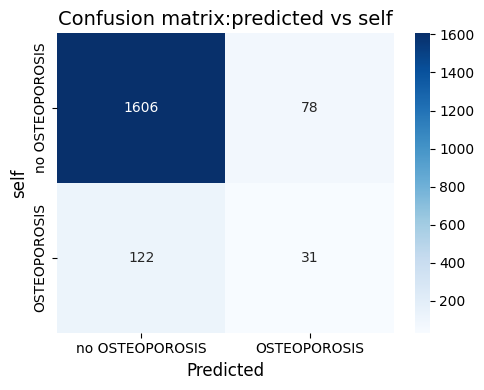

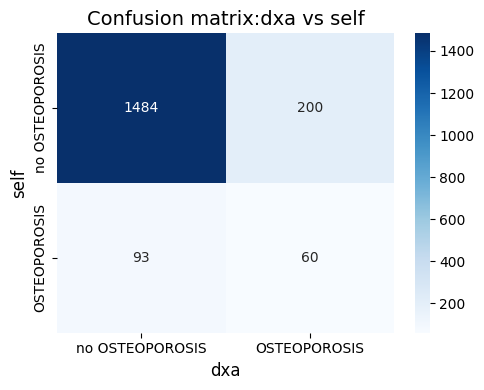

In [211]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# ========= ✨ STEP 1: 全體資料做 PSM =========

def do_psm_all(df):
    non_t2d = df[df['DIABETES_SELF'] == 0].copy()
    t2d = df[df['DIABETES_SELF'] == 1].copy()

    if non_t2d.empty or t2d.empty:
        print(f"⚠️ 資料不足無法做 PSM")
        return None, None

    # 用來配對的變數
    match_vars = ['AGE', 'BMI', 'WHR', 'QUS_T_SCORE', 'OSTEOPOROSIS_SELF', 'BODY_FAT_RATE',
                  'BODY_HEIGHT', 'BODY_WEIGHT', 'BODY_WAISTLINE', 'BODY_BUTTOCKS', 'QUS']

    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[match_vars])
    y = df['DIABETES_SELF']

    # Propensity score model
    ps_model = LogisticRegression().fit(X_all, y)
    df['pscore'] = ps_model.predict_proba(X_all)[:, 1]

    non_t2d = df[df['DIABETES_SELF'] == 0]
    t2d = df[df['DIABETES_SELF'] == 1]

    # Nearest neighbor matching (1:1)
    nn = NearestNeighbors(n_neighbors=1) 
    nn.fit(non_t2d[['pscore']])
    dists, indices = nn.kneighbors(t2d[['pscore']])
    matched_non_t2d = non_t2d.iloc[indices.flatten()].copy()

    return matched_non_t2d, t2d.copy()

# ========= ✨ STEP 2: 建模與預測 =========
predictors = ['OSTEOPOROSIS_SELF','AGE', 'BODY_HEIGHT',
    'QUS_T_SCORE', 'BODY_WEIGHT']
bmd_targets = ['Spine_Tot_T', 'HipL_Tot_T', 'HipR_Tot_T']

df['BMI*HbA1C'] = df['BMI'] * df['HBA1C']  # 設交互

# def model_and_predict(matched_non_t2d, t2d, predictors, bmd_targets):
#     if matched_non_t2d.empty or t2d.empty:
#         return pd.DataFrame()

#     for col in bmd_targets:
#         X_non = sm.add_constant(matched_non_t2d[predictors], has_constant='add')
#         y_non = matched_non_t2d[col]
#         model = sm.OLS(y_non, X_non).fit()

#         X_t2d = sm.add_constant(t2d[predictors], has_constant='add')
#         t2d[f'{col}_pred'] = model.predict(X_t2d)

def model_and_predict(matched_non_t2d, t2d, predictors, bmd_targets):
    if matched_non_t2d.empty or t2d.empty:
        return pd.DataFrame()

    for col in bmd_targets:
        X_non = sm.add_constant(matched_non_t2d[predictors], has_constant='add')
        y_non = matched_non_t2d[col]
        model = sm.OLS(y_non, X_non).fit()

        print(f"\n🧠 模型回歸結果 Summary：{col}")
        print(model.summary())  # <<< 加這行印 summary

        X_t2d = sm.add_constant(t2d[predictors], has_constant='add')
        t2d[f'{col}_pred'] = model.predict(X_t2d)

    return t2d

# ========= ✨ STEP 3: 一致性分析 =========

def evaluate_bone_match(df, bmd_targets, cutoff=-2.5):
    df['Min_T_actual'] = df[bmd_targets].min(axis=1)
    df['Min_T_pred'] = df[[f'{col}_pred' for col in bmd_targets]].min(axis=1)

    df['Actual_flag'] = (df['Min_T_actual'] <= cutoff).astype(int)
    df['Predicted_flag'] = (df['Min_T_pred'] <= cutoff).astype(int)
    df['Self_reported'] = df['OSTEOPOROSIS_SELF']

    eval_df = df[['Actual_flag', 'Predicted_flag', 'Self_reported']].dropna()

    actual_match = (eval_df['Actual_flag'] == eval_df['Self_reported']).mean()
    pred_match = (eval_df['Predicted_flag'] == eval_df['Self_reported']).mean()

    print(f"\n🩻 DXA 判定與自述一致比例：{actual_match:.2%}")
    print(f"🩻 校正預測與自述一致比例：{pred_match:.2%}")
    print(f"\n📊 自述骨鬆比率：{eval_df['Self_reported'].mean():.2%}")

# ========= ✨ STEP 4: 不分性別統一執行全流程 =========

cutoff = -2.5

# 做 PSM
matched_all, t2d_all = do_psm_all(df)

# 模型建構與預測
t2d_result = model_and_predict(matched_all, t2d_all, predictors, bmd_targets)

# 評估
print("\n=== 不分性別 → 全體 T2D PSM校正一致性分析 ===")
evaluate_bone_match(t2d_result, bmd_targets, cutoff)

def describe_prediction_gap(df):
    df = df[['Min_T_actual', 'Min_T_pred']].dropna()
    df['Gap'] = df['Min_T_actual'] - df['Min_T_pred']  # DXA - 預測
    df['Gap_abs'] = df['Gap'].abs()

    # 敘述統計
    mean_gap = df['Gap'].mean()
    median_gap = df['Gap'].median()
    std_gap = df['Gap'].std()
    max_gap = df['Gap'].max()
    min_gap = df['Gap'].min()

    positive_ratio = (df['Gap'] > 0).mean()
    large_gap_ratio = (df['Gap'].abs() > 0.5).mean()

    print("\n📏 DXA 與預測差距分析")
    print(f"➡️ DXA - 預測 的平均差：{mean_gap:.3f}")
    print(f"➡️ 中位數差距：{median_gap:.3f}")
    print(f"➡️ 標準差：{std_gap:.3f}")
    print(f"➡️ 最大差距：{max_gap:.3f}、最小差距：{min_gap:.3f}")
    print(f"\n📊 DXA > 預測 的比例（模型偏低）：{positive_ratio:.2%}")
    print(f"📊 差距 > 0.5 的比例（偏差明顯）：{large_gap_ratio:.2%}")
describe_prediction_gap(t2d_result)


# 混淆矩陣!!!!
cm = confusion_matrix(eval_df['Self_reported'], eval_df['Predicted_flag'])
labels = ['no OSTEOPOROSIS', 'OSTEOPOROSIS']

# 用 seaborn 畫 heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("self", fontsize=12)
plt.title("Confusion matrix:predicted vs self", fontsize=14)
plt.tight_layout()
plt.show()

##
cm = confusion_matrix(eval_df['Self_reported'], eval_df['Actual_flag'])
labels = ['no OSTEOPOROSIS', 'OSTEOPOROSIS']

# 用 seaborn 畫 heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel("dxa", fontsize=12)
plt.ylabel("self", fontsize=12)
plt.title("Confusion matrix:dxa vs self", fontsize=14)
plt.tight_layout()
plt.show()

## 瑤

In [131]:
import pandas as pd
import statsmodels.api as sm

# 🧠 設定資料與參數
predictors =['AGE*QUS_T_SCORE', 'BODY_WEIGHT', 'QUS', 'QUS_T_SCORE']
bmd_targets = ['Spine_Tot_T', 'HipL_Tot_T', 'HipR_Tot_T']
cutoff = -2.5  # 小於等於 -1 視為異常

df['AGE*QUS_T_SCORE'] = df['AGE'] * df['QUS_T_SCORE']

# 分性別建模與預測
def model_and_predict(df, sex_label):
    # 取出 non-T2D 該性別建模資料
    non_t2d = df[(df['DIABETES_SELF'] == 0) & (df['SEX'] == sex_label)].copy()
    t2d = df[(df['DIABETES_SELF'] == 1) & (df['SEX'] == sex_label)].copy()

    if non_t2d.empty or t2d.empty:
        print(f"⚠️ SEX = {sex_label} 無法建模或預測（樣本不足）")
        return pd.DataFrame()

    for col in bmd_targets:
        X_non = sm.add_constant(non_t2d[predictors], has_constant='add')
        y_non = non_t2d[col]
        model = sm.OLS(y_non, X_non).fit()

        X_t2d = sm.add_constant(t2d[predictors], has_constant='add')
        t2d[f'{col}_pred'] = model.predict(X_t2d)

    return t2d

# 分性別建模與預測
t2d_male = model_and_predict(df, sex_label=1)
t2d_female = model_and_predict(df, sex_label=2)

# 合併兩性別 T2D 預測結果
t2d_all = pd.concat([t2d_male, t2d_female], ignore_index=True)

# 補上實測與預測最低 T-score
t2d_all['Min_T_actual'] = t2d_all[bmd_targets].min(axis=1)
t2d_all['Min_T_pred'] = t2d_all[[f'{col}_pred' for col in bmd_targets]].min(axis=1)

# 判定是否異常（<= -1）
t2d_all['Actual_flag'] = (t2d_all['Min_T_actual'] <= cutoff).astype(int)
t2d_all['Predicted_flag'] = (t2d_all['Min_T_pred'] <= cutoff).astype(int)
t2d_all['Self_reported'] = t2d_all['OSTEOPOROSIS_SELF']

# 丟掉缺失
eval_df = t2d_all[['Actual_flag', 'Predicted_flag', 'Self_reported']].dropna()

# 一致性評估
def evaluate_bone_match(df):
    print("\n🩻 T2D 分性別建模 → 預測骨鬆 vs 自述骨鬆")

    actual_match = (df['Actual_flag'] == df['Self_reported']).mean()
    pred_match = (df['Predicted_flag'] == df['Self_reported']).mean()

    print(f"\n✅ DXA 判定與自述一致比例：{actual_match:.2%}")
    print(f"✅ 校正預測與自述一致比例：{pred_match:.2%}")

    print(f"\n📊 自述骨鬆比率：{df['Self_reported'].mean():.2%}")

# 執行結果評估
evaluate_bone_match(eval_df)



🩻 T2D 分性別建模 → 預測骨鬆 vs 自述骨鬆

✅ DXA 判定與自述一致比例：84.05%
✅ 校正預測與自述一致比例：89.11%

📊 自述骨鬆比率：8.33%


### 加psm

In [167]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# ========= ✨ STEP 1: 全體資料做 PSM =========

def do_psm_all(df):
    non_t2d = df[df['DIABETES_SELF'] == 0].copy()
    t2d = df[df['DIABETES_SELF'] == 1].copy()

    if non_t2d.empty or t2d.empty:
        print(f"⚠️ 資料不足無法做 PSM")
        return None, None

    # 用來配對的變數
    match_vars = ['AGE', 'BMI', 'WHR', 'QUS_T_SCORE', 'OSTEOPOROSIS_SELF', 'BODY_FAT_RATE',
                  'BODY_HEIGHT', 'BODY_WEIGHT', 'BODY_WAISTLINE', 'BODY_BUTTOCKS', 'QUS']

    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[match_vars])
    y = df['DIABETES_SELF']

    # Propensity score model
    ps_model = LogisticRegression().fit(X_all, y)
    df['pscore'] = ps_model.predict_proba(X_all)[:, 1]

    non_t2d = df[df['DIABETES_SELF'] == 0]
    t2d = df[df['DIABETES_SELF'] == 1]

    # Nearest neighbor matching (1:1)
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(non_t2d[['pscore']])
    dists, indices = nn.kneighbors(t2d[['pscore']])
    matched_non_t2d = non_t2d.iloc[indices.flatten()].copy()

    return matched_non_t2d, t2d.copy()

# ========= ✨ STEP 2: 建模與預測 =========
predictors =['AGE*QUS_T_SCORE', 'BODY_WEIGHT', 'QUS', 'QUS_T_SCORE']
bmd_targets = ['Spine_Tot_T', 'HipL_Tot_T', 'HipR_Tot_T']

df['AGE*QUS_T_SCORE'] = df['AGE'] * df['QUS_T_SCORE']

def model_and_predict(matched_non_t2d, t2d, predictors, bmd_targets):
    if matched_non_t2d.empty or t2d.empty:
        return pd.DataFrame()

    for col in bmd_targets:
        X_non = sm.add_constant(matched_non_t2d[predictors], has_constant='add')
        y_non = matched_non_t2d[col]
        model = sm.OLS(y_non, X_non).fit()

        X_t2d = sm.add_constant(t2d[predictors], has_constant='add')
        t2d[f'{col}_pred'] = model.predict(X_t2d)

    return t2d

# ========= ✨ STEP 3: 一致性分析 =========

def evaluate_bone_match(df, bmd_targets, cutoff=-2.5):
    df['Min_T_actual'] = df[bmd_targets].min(axis=1)
    df['Min_T_pred'] = df[[f'{col}_pred' for col in bmd_targets]].min(axis=1)

    df['Actual_flag'] = (df['Min_T_actual'] <= cutoff).astype(int)
    df['Predicted_flag'] = (df['Min_T_pred'] <= cutoff).astype(int)
    df['Self_reported'] = df['OSTEOPOROSIS_SELF']

    eval_df = df[['Actual_flag', 'Predicted_flag', 'Self_reported']].dropna()

    actual_match = (eval_df['Actual_flag'] == eval_df['Self_reported']).mean()
    pred_match = (eval_df['Predicted_flag'] == eval_df['Self_reported']).mean()

    print(f"\n🩻 DXA 判定與自述一致比例：{actual_match:.2%}")
    print(f"🩻 校正預測與自述一致比例：{pred_match:.2%}")
    print(f"\n📊 自述骨鬆比率：{eval_df['Self_reported'].mean():.2%}")

# ========= ✨ STEP 4: 不分性別統一執行全流程 =========

cutoff = -2.5

# 做 PSM
matched_all, t2d_all = do_psm_all(df)

# 模型建構與預測
t2d_result = model_and_predict(matched_all, t2d_all, predictors, bmd_targets)

# 評估
print("\n=== 不分性別 → 全體 T2D PSM校正一致性分析 ===")
evaluate_bone_match(t2d_result, bmd_targets, cutoff)



=== 不分性別 → 全體 T2D PSM校正一致性分析 ===

🩻 DXA 判定與自述一致比例：84.05%
🩻 校正預測與自述一致比例：90.15%

📊 自述骨鬆比率：8.33%


## final


📘 回歸模型 summary：Spine_Tot_T
                            OLS Regression Results                            
Dep. Variable:            Spine_Tot_T   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     147.0
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          3.00e-172
Time:                        21:17:26   Log-Likelihood:                -2928.7
No. Observations:                1837   AIC:                             5873.
Df Residuals:                    1829   BIC:                             5917.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const     

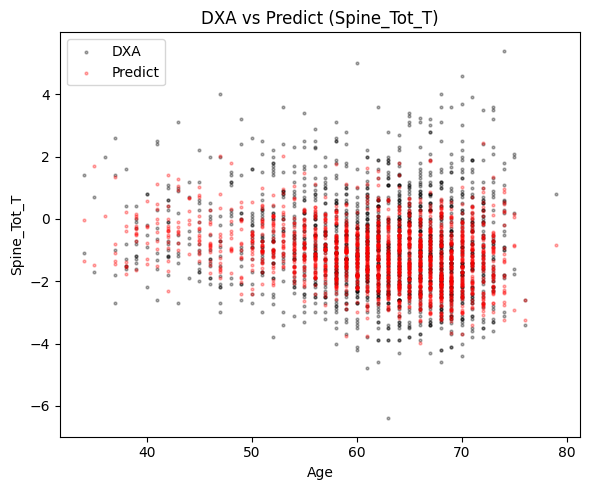


📊 差距統計 - Spine_Tot_T
平均差（DXA - 預測）: 0.285
標準差: 1.256
差距 > 0 的比例（DXA > 預測）: 56.02%
差距 > 0.5 的比例: 67.28%


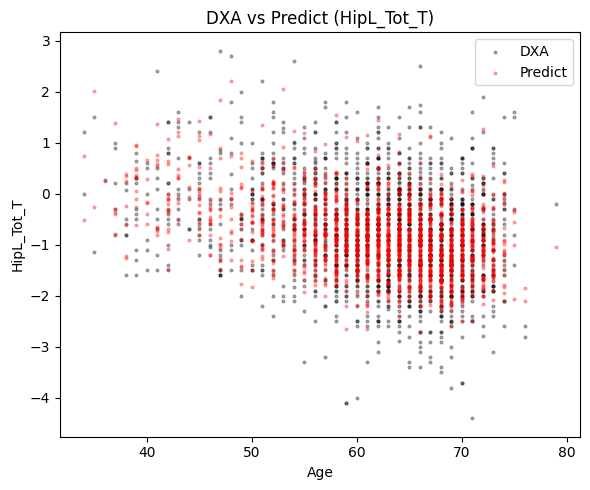


📊 差距統計 - HipL_Tot_T
平均差（DXA - 預測）: 0.118
標準差: 0.757
差距 > 0 的比例（DXA > 預測）: 55.47%
差距 > 0.5 的比例: 49.54%


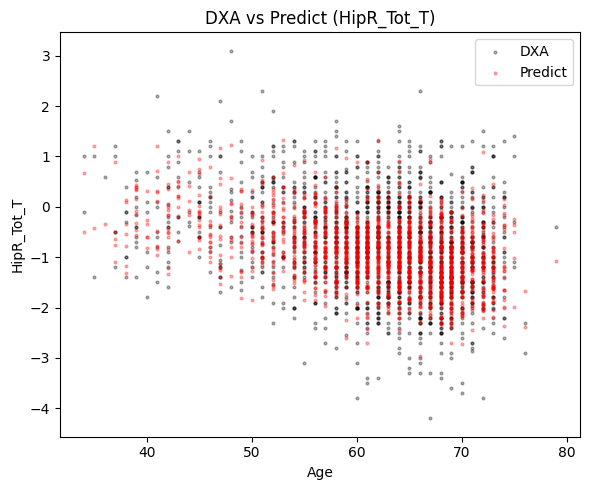


📊 差距統計 - HipR_Tot_T
平均差（DXA - 預測）: 0.159
標準差: 0.745
差距 > 0 的比例（DXA > 預測）: 58.41%
差距 > 0.5 的比例: 49.81%


In [232]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ==== STEP 0: 各部位專屬 predictors ====
predictors_dict = {
    'Spine_Tot_T':['AGE', 'SEX', 'BODY_HEIGHT', 'BODY_WEIGHT', 'QUS', 'AGE_x_SEX',
     'AGE_x_BODY_WEIGHT'],
    'HipL_Tot_T': ['AGE', 'SEX', 'BODY_WEIGHT', 'QUS', 'AGE_x_SEX','SEX_x_QUS'],
    'HipR_Tot_T': ['AGE', 'SEX', 'BODY_HEIGHT', 'BODY_WEIGHT', 'BODY_FAT_RATE', 'QUS',
     'AGE_x_BODY_HEIGHT', 'SEX_x_QUS', 'BODY_WEIGHT_x_BODY_FAT_RATE']
}
bmd_targets = list(predictors_dict.keys())
cutoff = -2.5

# 設交互
df['AGE_x_SEX'] = df['AGE'] * df['SEX']
df['AGE_x_BODY_HEIGHT'] = df['AGE'] * df['BODY_HEIGHT']
df['AGE_x_BODY_WEIGHT'] = df['AGE'] * df['BODY_WEIGHT']
df['AGE_x_QUS'] = df['AGE'] * df['QUS']
df['SEX_x_QUS'] = df['SEX'] * df['QUS']
df['BODY_HEIGHT_x_BODY_WEIGHT'] = df['BODY_HEIGHT'] * df['BODY_WEIGHT']
df['BODY_HEIGHT_x_QUS'] = df['BODY_HEIGHT'] * df['QUS']
df['SEX_x_BODY_WEIGHT'] = df['SEX'] * df['BODY_WEIGHT']
df['BODY_HEIGHT_x_HBA1C'] = df['BODY_HEIGHT'] * df['HBA1C']
df['BODY_WEIGHT_x_BODY_FAT_RATE'] = df['BODY_WEIGHT'] * df['BODY_FAT_RATE']
df['BODY_WEIGHT_x_HBA1C'] = df['BODY_WEIGHT'] * df['HBA1C']

# ==== STEP 1: PSM 不分性別 ====
def do_psm_all(df):
    non_t2d = df[df['DIABETES_SELF'] == 0].copy()
    t2d = df[df['DIABETES_SELF'] == 1].copy()

    match_vars = ['AGE', 'BMI', 'WHR', 'OSTEOPOROSIS_SELF', 'BODY_FAT_RATE',
                  'BODY_HEIGHT', 'BODY_WEIGHT']
    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[match_vars])
    y = df['DIABETES_SELF']

    ps_model = LogisticRegression().fit(X_all, y)
    df['pscore'] = ps_model.predict_proba(X_all)[:, 1]

    non_t2d = df[df['DIABETES_SELF'] == 0]
    t2d = df[df['DIABETES_SELF'] == 1]

    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(non_t2d[['pscore']])
    dists, indices = nn.kneighbors(t2d[['pscore']])
    matched_non_t2d = non_t2d.iloc[indices.flatten()].copy()

    return matched_non_t2d, t2d.copy()

# ==== STEP 2: 建模 & 預測 ====
def model_and_predict(non_t2d, t2d, predictors_dict):
    models = {}
    for col, pred_vars in predictors_dict.items():
        X = sm.add_constant(non_t2d[pred_vars])
        y = non_t2d[col]
        model = sm.OLS(y, X).fit()
        models[col] = model
        print(f"\n📘 回歸模型 summary：{col}")
        print(model.summary())

        X_pred = sm.add_constant(t2d[pred_vars])
        t2d[f'{col}_pred'] = model.predict(X_pred)
    return t2d, models

# ==== STEP 3: 圖形比較 + 統計 ====
def plot_scatter_and_stats(df, col):
    pred_col = f'{col}_pred'
    plt.figure(figsize=(6, 5))
    plt.scatter(df['AGE'], df[col], color='black', alpha=0.3, s=4, label='DXA')
    plt.scatter(df['AGE'], df[pred_col], color='red', alpha=0.3, s=4, label='Predict')
    plt.xlabel("Age")
    plt.ylabel(col)
    plt.title(f"DXA vs Predict ({col})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    diff = df[col] - df[pred_col]
    print(f"\n📊 差距統計 - {col}")
    print(f"平均差（DXA - 預測）: {diff.mean():.3f}")
    print(f"標準差: {diff.std():.3f}")
    print(f"差距 > 0 的比例（DXA > 預測）: {(diff > 0).mean():.2%}")
    print(f"差距 > 0.5 的比例: {(diff.abs() > 0.5).mean():.2%}")

# ==== STEP 4: 執行 ====
matched_all, t2d_all = do_psm_all(df)
t2d_result, models = model_and_predict(matched_all, t2d_all, predictors_dict)

# ==== STEP 5: 每部位散圖 + 統計 ====
for col in bmd_targets:
    plot_scatter_and_stats(t2d_result, col)
